# COVID-19 Detection in Chest X-Ray Images

The goal of this project is to build a model that identifies COVID-19, pneumonia in chest X-Ray images. The dataset is organized into 3 folders (COVID-19 cases, Normal , Pneumonia) and contains subfolders for each image category. There are 606 X-Ray images (JPEG). Data from Mendeley.

In [1]:
# ! pip install scikeras

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split as tts
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.metrics import F1Score, Precision, Recall
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed, Dropout, BatchNormalization, concatenate, Layer
from scikeras.wrappers import KerasClassifier
import scipy
import os
import math
from statistics import mean
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
current_path = os.getcwd()

# 1. Orignial data(224 * 224): [1 : Covid as positive; 0 : normal + Pneumonia ]

In [4]:
covid_data = pd.read_csv(current_path + '/csv/covid_data2.csv')
covid_data.sample(6)

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature50169,feature50170,feature50171,feature50172,feature50173,feature50174,feature50175,label,binary_label,Image_Path
551,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,False,Covid_Project/Pneumonia/person35_virus_80.jpeg
249,0.070588,0.074510,0.074510,0.074510,0.074510,0.074510,0.070588,0.070588,0.074510,0.074510,...,0.070588,0.070588,0.078431,0.082353,0.082353,0.082353,0.078431,1,False,Covid_Project/Normal /IM-0037-0001.jpeg
383,0.219608,0.243137,0.282353,0.301961,0.298039,0.309804,0.443137,0.533333,0.505882,0.486274,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,False,Covid_Project/Normal /NORMAL2-IM-0288-0001.jpeg
452,0.000000,0.027451,0.082353,0.137255,0.200000,0.239216,0.262745,0.298039,0.325490,0.352941,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,False,Covid_Project/Normal /NORMAL2-IM-0380-0001.jpeg
195,0.658824,0.576471,0.537255,0.505882,0.474510,0.466667,0.470588,0.474510,0.470588,0.470588,...,0.423529,0.450980,0.482353,0.505882,0.549020,0.670588,0.674510,0,True,Covid_Project/COVID-19 cases/pneumocystis-jiro...
208,0.090196,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.690196,0.760784,0.749020,0.670588,0.619608,0.631373,0.494118,0,True,Covid_Project/COVID-19 cases/radiol.2020201160...


In [5]:
# Calculate the frequency of each category (0: COVID; 1: Normal; 2: Pneumonia)

category_counts = covid_data['label'].value_counts()
category_counts 

label
1    234
0    220
2    148
Name: count, dtype: int64

In [6]:
# Set COVID as 1, normal and Pneumonia as 0

covid_data['binary_label_num'] = covid_data['binary_label'].apply(lambda x: 0 if not x else 1)
df = covid_data.copy()
df.drop(columns=['label','binary_label', 'Image_Path'],inplace=True)
df.sample(6)

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature50167,feature50168,feature50169,feature50170,feature50171,feature50172,feature50173,feature50174,feature50175,binary_label_num
59,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.72549,0.709804,0.694118,0.674510,0.662745,0.65098,0.635294,0.631373,0.611765,1
322,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078431,0.145098,0.152941,0.160784,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0
72,0.000000,0.000000,0.000000,0.000000,0.003922,0.443137,0.556863,0.274510,0.003922,0.000000,...,0.47451,0.427451,0.376471,0.258824,0.000000,0.00000,0.000000,0.000000,0.000000,1
432,0.356863,0.337255,0.329412,0.317647,0.309804,0.321569,0.333333,0.345098,0.360784,0.372549,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0
391,0.086275,0.113725,0.133333,0.156863,0.156863,0.172549,0.184314,0.196078,0.215686,0.215686,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0
370,0.447059,0.454902,0.458824,0.435294,0.407843,0.388235,0.341176,0.360784,0.333333,0.301961,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0


In [7]:
# Calculate the frequency for negative(0: Normal + Pneumonia) and positive (1: COVID)
counts = df['binary_label_num'].value_counts()
counts

binary_label_num
0    382
1    220
Name: count, dtype: int64

In [8]:
# split the dataset
from sklearn.model_selection import train_test_split

target = df['binary_label_num'].astype('float32')
features = df.drop(['binary_label_num'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

#### models were fine tuned in other files, here in this notebook, we only load those models won the best scores for each ML methods

Hyperparameters:

<img src="picture1.png" alt="My Image" width="600"/>

In [9]:
# .pkl model in this notebook need to use version 1.2.2 to unpacking
# If the belowing pkl file faied to loading, run this code: 
# !pip install scikit-learn==1.2.2

In [10]:
import pickle
# Load the models
model_path = current_path + '/model'
with open(model_path + '/best_lr_model_original_1.pkl', 'rb') as file:
    best_lr = pickle.load(file)

with open(model_path + '/best_decision_tree_model_original_1.pkl', 'rb') as file:
    best_dt = pickle.load(file)

with open(model_path + '/best_random_forest_model_original_1.pkl', 'rb') as file:
    best_rf = pickle.load(file)

with open(model_path + '/best_xgboost_model_original_1.pkl', 'rb') as file:
    best_xgb = pickle.load(file)

with open(model_path + '/best_svm_model_original_1.pkl', 'rb') as file:
    best_svm = pickle.load(file)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV

In [12]:
def get_score(model, X_test, y_test):

    test_preds = model.predict(X_test)
    accuracy=accuracy_score(y_test,test_preds)
    recall=recall_score(y_test,test_preds)
    precision=precision_score(y_test,test_preds)
    f1 = f1_score(y_test, test_preds)
    
    return accuracy, recall, precision, f1

In [13]:
def add_to_dict(model_dict, name, accuracy, precision, recall, f1):
    model_dict['Name'].append(name)
    model_dict['Accuracy'].append(accuracy)
    model_dict['Precision'].append(precision)
    model_dict['Recall'].append(recall)
    model_dict['F1_score'].append(f1)

In [14]:
best_model_dict_1 = {'Name':[],
                     'Accuracy': [],
                     'Precision': [],
                     'Recall': [],
                     'F1_score': []}

# best lr
accuracy, recall, precision, f1 = get_score(best_lr, X_test, y_test)
add_to_dict(best_model_dict_1, 'Logistic Regression', accuracy, precision, recall, f1)

# best dt
accuracy, recall, precision, f1 = get_score(best_dt, X_test, y_test)
add_to_dict(best_model_dict_1, 'Decision Tree', accuracy, precision, recall, f1)

# best rf
accuracy, recall, precision, f1 = get_score(best_rf, X_test, y_test)
add_to_dict(best_model_dict_1, 'Random Forest', accuracy, precision, recall, f1)

# best xgb
accuracy, recall, precision, f1 = get_score(best_xgb, X_test, y_test)
add_to_dict(best_model_dict_1, 'Xgboost', accuracy, precision, recall, f1)

# best vm
accuracy, recall, precision, f1 = get_score(best_svm, X_test, y_test)
add_to_dict(best_model_dict_1, 'Support vector machine', accuracy, precision, recall, f1)

# print results
results_1= pd.DataFrame(best_model_dict_1)
results_1
#results_1.to_csv('result_orignial_data.csv', index=False)

,Name,Accuracy,Precision,Recall,F1_score
0,Logistic Regression,0.950276,0.959459,0.922078,0.940397
1,Decision Tree,0.839779,0.887097,0.714286,0.791367
2,Random Forest,0.939227,0.934211,0.922078,0.928105
3,Xgboost,0.955801,0.985915,0.909091,0.945946
4,Support vector machine,0.950276,0.935897,0.948052,0.941935


# 2. Crop + Augument data (256 * 256): [1: Covid; 0: normal + Pneumonia]

In [15]:
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

df=pd.read_csv(current_path +'/csv/covid_data_augmented_train.csv')
df_test=pd.read_csv(current_path +'/csv/covid_data_test.csv')
df_test_out=pd.read_csv(current_path +'/csv/Outside_test_set_cropped.csv')

In [16]:
df.head()

,Unnamed: 0,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,...,feature65529,feature65530,feature65531,feature65532,feature65533,feature65534,feature65535,label,binary_label,Image_Path
0,0,0.043137,0.062745,0.070588,0.086275,0.101961,0.109804,0.129412,0.141176,0.145098,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,0,Covid_Project/Normal /NORMAL2-IM-0338-0001.jpeg
1,1,0.780392,0.949020,0.992157,0.996078,0.992157,0.850980,0.337255,0.345098,0.337255,...,0.772549,0.768627,0.756863,0.749020,0.745098,0.737255,0.745098,0,1,Covid_Project/COVID-19 cases/nCoV-radiol.20202...
2,2,0.168627,0.176471,0.196078,0.207843,0.215686,0.227451,0.262745,0.270588,0.282353,...,0.725490,0.600000,0.580392,0.592157,0.537255,0.407843,0.321569,2,0,Covid_Project/Normal /NORMAL2-IM-0310-0001.jpeg
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,Covid_Project/Pneumonia/person45_virus_95.jpeg
4,4,0.137255,0.129412,0.133333,0.141176,0.149020,0.160784,0.168627,0.184314,0.200000,...,0.607843,0.603922,0.607843,0.603922,0.603922,0.611765,0.615686,0,1,Covid_Project/COVID-19 cases/covid-19-pneumoni...


In [17]:
df_test.head()

,Unnamed: 0,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,...,feature65529,feature65530,feature65531,feature65532,feature65533,feature65534,feature65535,label,binary_label,Image_Path
0,0,0.396078,0.396078,0.392157,0.400000,0.403922,0.400000,0.392157,0.396078,0.392157,...,0.807843,0.807843,0.792157,0.756863,0.725490,0.709804,0.701961,0,1,Covid_Project/COVID-19 cases/MERS-CoV-1-s2.0-S...
1,1,0.321569,0.345098,0.349020,0.356863,0.372549,0.376471,0.376471,0.384314,0.376471,...,0.717647,0.717647,0.701961,0.686275,0.682353,0.678431,0.654902,0,1,Covid_Project/COVID-19 cases/6CB4EFC6-68FA-4CD...
2,2,0.184314,0.184314,0.196078,0.215686,0.219608,0.215686,0.215686,0.219608,0.239216,...,0.560784,0.549020,0.384314,0.286275,0.258824,0.219608,0.188235,2,0,Covid_Project/Normal /NORMAL2-IM-0340-0001.jpeg
3,3,0.521569,0.486274,0.450980,0.443137,0.443137,0.435294,0.435294,0.439216,0.458824,...,0.188235,0.039216,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,Covid_Project/COVID-19 cases/covid-19-pneumoni...
4,4,0.454902,0.466667,0.482353,0.490196,0.490196,0.498039,0.498039,0.505882,0.509804,...,0.423529,0.396078,0.427451,0.360784,0.247059,0.196078,0.184314,1,0,Covid_Project/Pneumonia/person54_virus_109.jpeg


In [18]:
df_test_out.head()

,Unnamed: 0,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,...,feature65529,feature65530,feature65531,feature65532,feature65533,feature65534,feature65535,label,binary_label,Image_Path
0,0,0.098039,0.098039,0.098039,0.098039,0.098039,0.098039,0.101961,0.101961,0.101961,...,0.047059,0.047059,0.047059,0.050980,0.050980,0.050980,0.054902,0,1,/Users/johnprichard/Capstone/COVID-19_Radiogra...
1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.662745,0.647059,0.643137,0.639216,0.627451,0.615686,0.600000,0,1,/Users/johnprichard/Capstone/COVID-19_Radiogra...
2,2,0.180392,0.180392,0.180392,0.180392,0.184314,0.188235,0.192157,0.196078,0.200000,...,0.415686,0.411765,0.403922,0.396078,0.388235,0.376471,0.360784,0,1,/Users/johnprichard/Capstone/COVID-19_Radiogra...
3,3,0.000000,0.003922,0.047059,0.152941,0.250980,0.290196,0.282353,0.258824,0.247059,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,/Users/johnprichard/Capstone/COVID-19_Radiogra...
4,4,0.396078,0.431373,0.443137,0.450980,0.435294,0.407843,0.400000,0.400000,0.423529,...,0.003922,0.003922,0.000000,0.000000,0.000000,0.000000,0.003922,0,1,/Users/johnprichard/Capstone/COVID-19_Radiogra...


In [19]:
df.drop(columns=['Unnamed: 0'],inplace=True)
df_test.drop(columns=['Unnamed: 0'],inplace=True)
df_test_out.drop(columns=['Unnamed: 0'],inplace=True)

In [20]:
df.reset_index(inplace=True)
df_test.reset_index(inplace=True)
df_test_out.reset_index(inplace=True)

In [21]:
df.drop(columns=['index'],inplace=True)
df_test.drop(columns=['index'],inplace=True)
df_test_out.drop(columns=['index'],inplace=True)

# 2.1 Exploratory Data Analysis

In [22]:
missing_sum = df.isna().sum()
missing_sum

feature0        0
feature1        0
feature2        0
feature3        0
feature4        0
               ..
feature65534    0
feature65535    0
label           0
binary_label    0
Image_Path      0
Length: 65539, dtype: int64

In [23]:
max(missing_sum)

0

In [24]:
df['feature0'].groupby(df['binary_label']).count()

binary_label
0    622
1    282
Name: feature0, dtype: int64

In [25]:
covid_data_describe = df.describe().T
covid_data_describe

,count,mean,std,min,25%,50%,75%,max
feature0,904.0,0.313552,0.262401,0.0,0.058824,0.286275,0.513726,1.0
feature1,904.0,0.322553,0.259273,0.0,0.066667,0.305882,0.518627,1.0
feature2,904.0,0.330960,0.256919,0.0,0.078431,0.317647,0.525490,1.0
feature3,904.0,0.341090,0.255441,0.0,0.090196,0.331373,0.537255,1.0
feature4,904.0,0.351805,0.254505,0.0,0.101961,0.345098,0.549020,1.0
...,...,...,...,...,...,...,...,...
feature65533,904.0,0.321326,0.240519,0.0,0.086275,0.307843,0.506863,1.0
feature65534,904.0,0.310255,0.240344,0.0,0.074510,0.298039,0.495098,1.0
feature65535,904.0,0.299740,0.238973,0.0,0.074510,0.280392,0.479412,1.0
label,904.0,1.110619,0.850339,0.0,0.000000,1.000000,2.000000,2.0


In [26]:
covid_data_describe.reset_index(inplace=True)

In [27]:
rng = []
len_data = len(covid_data_describe)
for i in range(len(covid_data_describe)):
  rng += [covid_data_describe.loc[i]['max'] - covid_data_describe.loc[i]['min']]
covid_data_describe['range'] = rng

In [28]:
covid_data_describe['range'].min()

0.6627450883388519

In [29]:
minmax_corr = pd.DataFrame(columns = ['firstcol','lastcol','min','avg','max'])
for i in range(int(len(df.columns)/5)):
  corr_all_matrix = df.iloc[:,5*i:min(5*(i+1),len(df.columns))].select_dtypes(include = "number").corr()
  corr_all_df = corr_all_matrix.stack().reset_index()
  corr_all_df.columns = ['v1', 'v2', 'correlation']
  minmax_corr.loc[len(minmax_corr)] = [df.columns[5*i],df.columns[min(5*(i+1),len(df.columns)-1)],min(corr_all_df.correlation.abs()),mean(corr_all_df.correlation.abs()),max(corr_all_df.correlation.abs())]
  # corr_all_df_sort = corr_all_df.loc[corr_all_df.correlation.abs().sort_values(ascending= False).index]
  # print(corr_all_df_sort.loc[(corr_all_df_sort.v1 != corr_all_df_sort.v2) & (corr_all_df_sort.correlation.abs() > 0.8)])
print(minmax_corr)

           firstcol       lastcol       min       avg  max
0          feature0      feature5  0.891030  0.957267  1.0
1          feature5     feature10  0.878315  0.950301  1.0
2         feature10     feature15  0.889681  0.957228  1.0
3         feature15     feature20  0.880894  0.960879  1.0
4         feature20     feature25  0.896341  0.958279  1.0
...             ...           ...       ...       ...  ...
13102  feature65510  feature65515  0.897528  0.963039  1.0
13103  feature65515  feature65520  0.902509  0.965627  1.0
13104  feature65520  feature65525  0.885113  0.954388  1.0
13105  feature65525  feature65530  0.883465  0.956552  1.0
13106  feature65530  feature65535  0.908114  0.970366  1.0

[13107 rows x 5 columns]


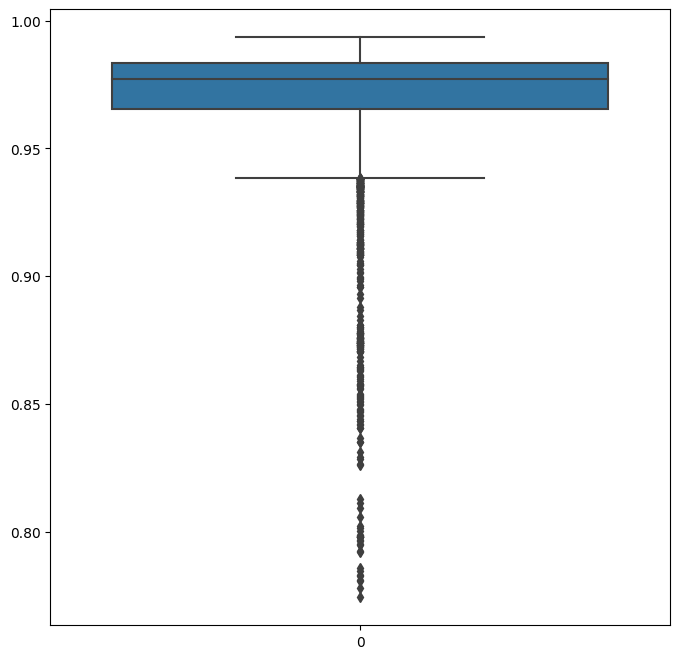

In [30]:
plt.figure(figsize = (8,8))
sns.boxplot(minmax_corr['avg'])
plt.show()

In [31]:
covid_data_5 = df[[f"feature{i*5}" for i in range(int(len(df.columns)/5))]]

In [32]:
minmax_corr2 = pd.DataFrame(columns = ['firstcol','lastcol','min','avg','max'])
for i in range(int(len(covid_data_5.columns)/5)):
  corr_all_matrix = covid_data_5.iloc[:,5*i:min(5*(i+1),len(covid_data_5.columns))].select_dtypes(include = "number").corr()
  corr_all_df = corr_all_matrix.stack().reset_index()
  corr_all_df.columns = ['v1', 'v2', 'correlation']
  minmax_corr2.loc[len(minmax_corr2)] = [covid_data_5.columns[5*i],covid_data_5.columns[min(5*(i+1),len(covid_data_5.columns)-1)],min(corr_all_df.correlation.abs()),mean(corr_all_df.correlation.abs()),max(corr_all_df.correlation.abs())]
print(minmax_corr2)

          firstcol       lastcol       min       avg  max
0         feature0     feature25  0.584655  0.796792  1.0
1        feature25     feature50  0.780590  0.906164  1.0
2        feature50     feature75  0.883784  0.951339  1.0
3        feature75    feature100  0.847422  0.937222  1.0
4       feature100    feature125  0.861473  0.934422  1.0
...            ...           ...       ...       ...  ...
2616  feature65400  feature65425  0.906182  0.944989  1.0
2617  feature65425  feature65450  0.836949  0.931270  1.0
2618  feature65450  feature65475  0.845772  0.937411  1.0
2619  feature65475  feature65500  0.818075  0.934288  1.0
2620  feature65500  feature65525  0.707450  0.856393  1.0

[2621 rows x 5 columns]


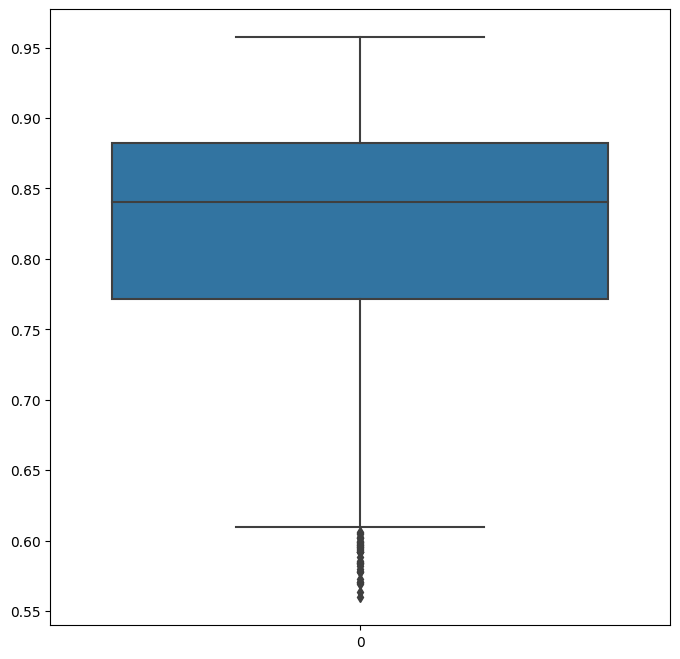

In [33]:
plt.figure(figsize = (8,8))
sns.boxplot(minmax_corr2['avg'])
plt.show()

In [34]:
covid_data_25 = df[[f"feature{i*25}" for i in range(int(len(df.columns)/25))]]

In [35]:
minmax_corr3 = pd.DataFrame(columns = ['firstcol','lastcol','min','avg','max'])
for i in range(int(len(covid_data_25.columns)/5)):
  corr_all_matrix = covid_data_25.iloc[:,5*i:min(5*(i+1),len(covid_data_25.columns))].select_dtypes(include = "number").corr()
  corr_all_df = corr_all_matrix.stack().reset_index()
  corr_all_df.columns = ['v1', 'v2', 'correlation']
  minmax_corr3.loc[len(minmax_corr3)] = [covid_data_25.columns[5*i],covid_data_25.columns[min(5*(i+1),len(covid_data_25.columns))],min(corr_all_df.correlation.abs()),mean(corr_all_df.correlation.abs()),max(corr_all_df.correlation.abs())]
print(minmax_corr3)

         firstcol       lastcol       min       avg  max
0        feature0    feature125  0.206202  0.655821  1.0
1      feature125    feature250  0.579938  0.784276  1.0
2      feature250    feature375  0.269322  0.660076  1.0
3      feature375    feature500  0.632474  0.797846  1.0
4      feature500    feature625  0.395488  0.671021  1.0
..            ...           ...       ...       ...  ...
519  feature64875  feature65000  0.666118  0.818158  1.0
520  feature65000  feature65125  0.224020  0.637980  1.0
521  feature65125  feature65250  0.697740  0.830043  1.0
522  feature65250  feature65375  0.278064  0.663257  1.0
523  feature65375  feature65500  0.696786  0.833121  1.0

[524 rows x 5 columns]


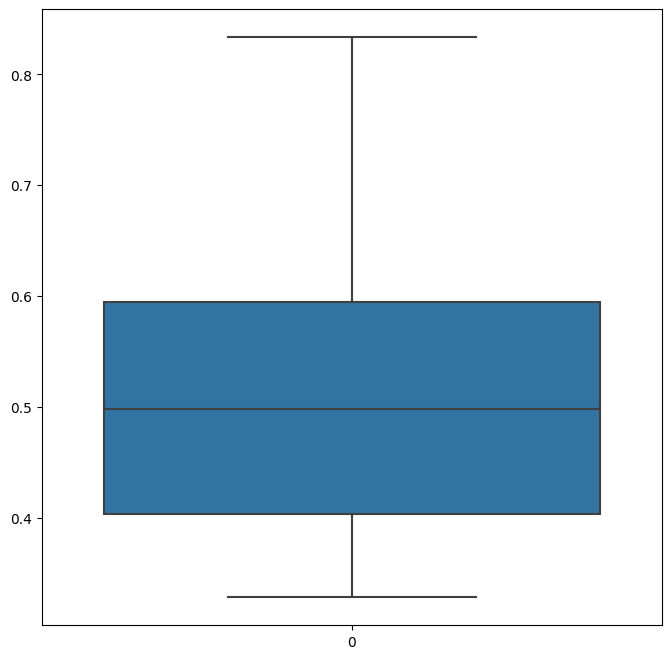

In [36]:
plt.figure(figsize = (8,8))
sns.boxplot(minmax_corr3['avg'])
plt.show()

In [37]:
features=[col for col in df.columns if col not in ['label','binary_label','Image_Path']]
X_train=df[features]
X_test=df_test[features]
X_test_out=df_test_out[features]
y_train=df['binary_label']
y_test=df_test['binary_label']
y_test_out=df_test_out['binary_label']

## 2.2 Hyperparameters:

models were tuned in other jupyter notebook files, the hyperparameters for lr, dt, rf, xgb, svm models are as bellow:

<img src="picture2.png" alt="My Image" width="600"/>

## 2.3 Fine tuned lr, dt, rf, xgb, svm models:

In [38]:
# .pkl model need to use version 1.2.2 to unpacking
# If the belowing pkl file faied to loading, run this code: 
# !pip install scikit-learn==1.2.2

In [39]:
# Load the lr, dt, rf, xgb, svm models
with open(model_path + '/best_lr_model_augument_1.pkl', 'rb') as file:
    best_lr = pickle.load(file)

with open(model_path + '/best_decision_tree_model_augument_1.pkl', 'rb') as file:
    best_dt = pickle.load(file)

with open(model_path + '/best_random_forest_model_augument_1_1.pkl', 'rb') as file:
    best_rf_1 = pickle.load(file)

with open(model_path + '/best_random_forest_model_augument_1_2.pkl', 'rb') as file:
    best_rf_2 = pickle.load(file)

with open(model_path + '/best_xgboost_model_augument_1.pkl', 'rb') as file:
    best_xgb = pickle.load(file)

with open(model_path + '/best_svm_model_augument_1.pkl', 'rb') as file:
    best_svm_rbf = pickle.load(file)

with open(model_path + '/best_svm_linear_model_augument_1.pkl', 'rb') as file:
    best_svm_linear = pickle.load(file)

## 2.3.1 Evaluation on test set

In [40]:


best_model_dict_2 = {'Name':[],
                     'Accuracy': [],
                     'Precision': [],
                     'Recall': [],
                     'F1_score': []}

# best lr
accuracy, recall, precision, f1 = get_score(best_lr, X_test, y_test)
add_to_dict(best_model_dict_2, 'Logistic Regression', accuracy, precision, recall, f1)

# best dt
accuracy, recall, precision, f1 = get_score(best_dt, X_test, y_test)
add_to_dict(best_model_dict_2, 'Decision Tree', accuracy, precision, recall, f1)

# best rf_1
accuracy, recall, precision, f1 = get_score(best_rf_1, X_test, y_test)
add_to_dict(best_model_dict_2, 'Random Forest_1', accuracy, precision, recall, f1)

# best rf_2
accuracy, recall, precision, f1 = get_score(best_rf_2, X_test, y_test)
add_to_dict(best_model_dict_2, 'Random Forest_1', accuracy, precision, recall, f1)

# best xgb
accuracy, recall, precision, f1 = get_score(best_xgb, X_test, y_test)
add_to_dict(best_model_dict_2, 'Xgboost', accuracy, precision, recall, f1)

# best svm rbf
accuracy, recall, precision, f1 = get_score(best_svm_rbf, X_test, y_test)
add_to_dict(best_model_dict_2, 'Supper Vector Machine: rbf', accuracy, precision, recall, f1)

# best svm linear
accuracy, recall, precision, f1 = get_score(best_svm_linear, X_test, y_test)
add_to_dict(best_model_dict_2, 'Supper Vector Machine: linear', accuracy, precision, recall, f1)

results_2 = pd.DataFrame(best_model_dict_2)
results_2

#results_2.to_csv('result_augument_data_1.csv', index=False)

,Name,Accuracy,Precision,Recall,F1_score
0,Logistic Regression,0.920354,0.883721,0.904762,0.894118
1,Decision Tree,0.849558,0.820513,0.761905,0.790123
2,Random Forest_1,0.938053,0.948718,0.880952,0.913580
3,Random Forest_1,0.938053,0.948718,0.880952,0.913580
4,Xgboost,0.964602,0.975000,0.928571,0.951220
5,Supper Vector Machine: rbf,0.938053,0.948718,0.880952,0.913580
6,Supper Vector Machine: linear,0.929204,0.925000,0.880952,0.902439


## 2.3.1 Evaluation on outside test set

In [41]:
best_model_dict_3 = {'Name':[],
                     'Accuracy': [],
                     'Precision': [],
                     'Recall': [],
                     'F1_score': []}

# best lr
accuracy, recall, precision, f1 = get_score(best_lr, X_test_out, y_test_out)
add_to_dict(best_model_dict_3, 'Logistic Regression', accuracy, precision, recall, f1)

# best dt
accuracy, recall, precision, f1 = get_score(best_dt, X_test_out, y_test_out)
add_to_dict(best_model_dict_3, 'Decision Tree', accuracy, precision, recall, f1)

# best rf_1
accuracy, recall, precision, f1 = get_score(best_rf_1, X_test_out, y_test_out)
add_to_dict(best_model_dict_3, 'Random Forest_1', accuracy, precision, recall, f1)

# best rf_2
accuracy, recall, precision, f1 = get_score(best_rf_2, X_test_out, y_test_out)
add_to_dict(best_model_dict_3, 'Random Forest_2', accuracy, precision, recall, f1)

# best xgb
accuracy, recall, precision, f1 = get_score(best_xgb, X_test_out, y_test_out)
add_to_dict(best_model_dict_3, 'Xgboost', accuracy, precision, recall, f1)

# best svm rbf
accuracy, recall, precision, f1 = get_score(best_svm_rbf, X_test_out, y_test_out)
add_to_dict(best_model_dict_3, 'Supper Vector Machine: rbf', accuracy, precision, recall, f1)

# best svm linear
accuracy, recall, precision, f1 = get_score(best_svm_linear, X_test_out, y_test_out)
add_to_dict(best_model_dict_3, 'Supper Vector Machine: linear', accuracy, precision, recall, f1)

results_3 = pd.DataFrame(best_model_dict_3)
results_3

# results_3.to_csv('result_outside_test_data.csv', index=False)

,Name,Accuracy,Precision,Recall,F1_score
0,Logistic Regression,0.72375,0.681542,0.8400,0.752520
1,Decision Tree,0.65750,0.654412,0.6675,0.660891
2,Random Forest_1,0.73250,0.686000,0.8575,0.762222
3,Random Forest_2,0.73250,0.690574,0.8425,0.759009
4,Xgboost,0.72875,0.692632,0.8225,0.752000
5,Supper Vector Machine: rbf,0.72875,0.666667,0.9150,0.771338
6,Supper Vector Machine: linear,0.72375,0.668550,0.8875,0.762621


Random Forest_1 and super vector machine rbf model were chosen since they performance better on both inside and outside test data.

In [42]:
import tensorflow as tf
def print_confusion_matrix(y_actual,preds=None,probabilities=None,title="",pred_proba=0.5):
    if probabilities is not None:
        preds=[(prob>pred_proba).astype(int) for prob in probabilities]
    conf_mat=tf.math.confusion_matrix(y_actual, preds)
    true_negatives = conf_mat[0, 0]
    false_positives = conf_mat[0, 1]
    false_negatives = conf_mat[1, 0]
    true_positives = conf_mat[1, 1]
    print(f'\nConfusion Matrix {title}')
    print(f"\tTrue Negatives: {true_negatives}\n\tFalse Positives: {false_positives}\n\tFalse Negatives: {false_negatives}\n\tTrue Positive: {true_positives}")

# 2.4 Baseline Neural Network

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
model_nn = Sequential([
  Dense(units=64, activation='relu'),  # Input layer with feature size
  Dense(units=32, activation='relu'),
  Dense(units=1, activation='sigmoid')])

In [44]:
from tensorflow.keras import optimizers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

# Compile the model
model_nn.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy','recall'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)
model_nn.fit(X_train, y_train, epochs=15, batch_size=128, validation_split = 0.15,callbacks=[early_stopping])

Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.6522 - loss: 5.0007 - recall: 0.2548 - val_accuracy: 0.6985 - val_loss: 4.1900 - val_recall: 0.0000e+00
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6376 - loss: 3.0982 - recall: 0.2060 - val_accuracy: 0.6985 - val_loss: 1.4717 - val_recall: 0.0000e+00
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6872 - loss: 1.1669 - recall: 0.2346 - val_accuracy: 0.6985 - val_loss: 0.6488 - val_recall: 0.0000e+00
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7373 - loss: 0.5925 - recall: 0.2807 - val_accuracy: 0.8162 - val_loss: 0.3378 - val_recall: 0.4634
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8270 - loss: 0.3740 - recall: 0.5332 - val_accuracy: 0.8971 - val_loss: 0.2659 - val_recall: 0.8049
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8806 - loss: 0.2877 - recall: 0.7386 - val_accuracy: 0.9265 - val_loss: 0.2549 - val_recall: 0.9268
Epoch 7/1

In [45]:
pred_probs=model_nn.predict(X_test) #Obtain probabilities for each test image
# test_loss, test_accuracy,test_recall = model_nn.evaluate(X_test_scaled, y_test)
test_loss, test_accuracy,test_recall = model_nn.evaluate(X_test, y_test)
print("Neural Network Test Accuracy", test_accuracy)
print("Neural Network Test Recall",test_recall)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8992 - loss: 0.2562 - recall: 0.9223 
Neural Network Test Accuracy 0.8938053250312805
Neural Network Test Recall 0.8809523582458496


In [46]:
print_confusion_matrix(y_test, probabilities=pred_probs.reshape(-1,), title='Neural Network')


Confusion Matrix Neural Network
	True Negatives: 64
	False Positives: 7
	False Negatives: 5
	True Positive: 37


## 2.5 Tuned Neural Network

## 2.5.1 Model trainning

In [47]:
X_train_removed_array = X_train.to_numpy()
X_train_3D = X_train_removed_array.reshape(X_train.shape[0],256,256)
X_test_removed_array = X_test.to_numpy()
X_test_3D = X_test_removed_array.reshape(X_test.shape[0],256,256)

In [48]:
#Create callback to save the weights after each epoch
class customCallback(callbacks.Callback):
  def on_train_begin(self,logs=None):
    self.model.all_weights = []
  def on_epoch_end(self,epoch,logs=None):
    self.weight_list = []
    for layer in self.model.layers:
      if layer.get_weights() == []:
        self.weight_list += [np.nan]
      else:
        self.weight_list += [np.mean(layer.get_weights()[0])]
    self.model.all_weights += [self.weight_list]

In [49]:
from keras import layers, models, utils
@utils.register_keras_serializable(package="my_package", name="add_layer")
# @keras.utils.register_keras_serializable(package="my_package", name="add_layer")
def add_layer(model,num_layer,neurons):
  for i in range(num_layer):
    model.add(Dense(neurons,activation='relu'))

In [50]:
@utils.register_keras_serializable(package="my_package", name="add_layer_lr")
#@keras.utils.register_keras_serializable(package="my_package", name="add_layer_lr")
def add_layer_lr(model,num_layer,neurons,slope):
  act = tf.keras.layers.LeakyReLU(negative_slope=slope)
  for i in range(num_layer):
    model.add(Dense(neurons,activation=act))

In [51]:
#!pip install --upgrade tensorflow keras


In [52]:
def create_nn_5_128(input_shape):
    model = Sequential() # Creates instance of Sequential model, model for NN where layers are added up in sequence (One input tensor and one output tensor)
    model.add(Conv2D(filters=100, kernel_size=5, activation='relu', input_shape=input_shape)) # 1D convolutional layer to model, 64 neurons, each filter extracts different features from input data
    # Kernel size 3, each filter covers 3 units in the input dimension. Relu, allows the model to capture non-linear relationships
    model.add(MaxPooling2D(pool_size=2)) # Layer reduces the dimensionality of the data by taking the max value over a window of 2 units along each feature dimension
    # Makes the model more efficient and less sensitive to small variation in the position of features
    model.add(Flatten()) # Adds flatten layer, converts multidimensional output of previous layers into a 1D array for fully connected layer
    model.add(Dense(128, activation='relu')) # Adds dense layer (fully connected), 50 neurons and again uses relu activation
    add_layer(model,5,128)
    model.add(Dense(64, activation='relu')) # Adds dense layer (fully connected), 50 neurons and again uses relu activation
    model.add(Dense(32, activation='relu')) # Adds dense layer (fully connected), 50 neurons and again uses relu activation
    model.add(Dense(1, activation='sigmoid'))  # Adds another dense layer, 1 unit for output layer, single neuron whose task is regression. Activation is linear for regression
    opt = tf.keras.optimizers.Adam(learning_rate=0.005, beta_1=0.999, beta_2=0.999)
    f1_score = tf.keras.metrics.F1Score(threshold=0.5)
    precision = tf.keras.metrics.Precision(thresholds=0.5)
    recall = tf.keras.metrics.Recall(thresholds=0.5)
    model.compile(optimizer=opt, loss=BinaryCrossentropy(), metrics=['accuracy',f1_score,precision,recall]) # Compiles the model, uses Adam optimizer which combines the advantages of Adaptive Gradient Algorithm and Root Mean Square Propagation
    # Uses MSE as loss function, typical for regression task
    return model

input_shape = (256,256,1)  # 12 features, 1 row per input
nn_model_5_128 = create_nn_5_128(input_shape)
nn_model_5_128.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 252, 252, 100)  │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 100)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1587600)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │   203,212,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,308,457 (775.56 MB)

 Trainable params: 203,308,457 (775.56 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
model_5_128_history = nn_model_5_128.fit(X_train_3D, y_train, epochs=15, batch_size=32, callbacks=[customCallback()], validation_split=0.15)

Epoch 1/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.5742 - f1_score: 0.2830 - loss: 6.1115 - precision: 0.3050 - recall_1: 0.3180 - val_accuracy: 0.6985 - val_f1_score: 0.0000e+00 - val_loss: 0.4709 - val_precision: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.7027 - f1_score: 0.0000e+00 - loss: 0.4320 - precision: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.6985 - val_f1_score: 0.0000e+00 - val_loss: 0.3580 - val_precision: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.7731 - f1_score: 0.4206 - loss: 0.3272 - precision: 0.6565 - recall_1: 0.3525 - val_accuracy: 0.8750 - val_f1_score: 0.8247 - val_loss: 0.3441 - val_precision: 0.7143 - val_recall_1: 0.9756
Epoch 4/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.9187 - f1_score: 0.8760 - loss: 0.2191 - precision: 0.8046 - recall_1: 0.9634 - val_accuracy: 0.9191 - val_f1_score: 0.8736 - val_loss: 

In [54]:
model_df = pd.DataFrame(columns=['epoch','train_f1_score','val_f1_score','train_precision','val_precision','train_recall','val_recall','train_loss','val_loss'])
model_df['epoch'] = model_5_128_history.epoch
model_df['train_f1_score'] = model_5_128_history.history['f1_score']
model_df['val_f1_score'] = model_5_128_history.history['val_f1_score']
model_df['train_precision'] = model_5_128_history.history['precision']
model_df['val_precision'] = model_5_128_history.history['val_precision']
# model_df['train_recall'] = model_5_128_history.history['recall']
model_df['train_recall'] = model_5_128_history.history['recall_1']
# model_df['val_recall'] = model_5_128_history.history['val_recall']
model_df['val_recall'] = model_5_128_history.history['val_recall_1']
model_df['train_loss'] = model_5_128_history.history['loss']
model_df['val_loss'] = model_5_128_history.history['val_loss']

name = []
for layer in nn_model_5_128.layers:
  name += [str(type(layer)).split("'")[1].split(".")[5]]
name_count = pd.Series(name).value_counts()
name_count_dict = name_count.to_dict()
for i in name_count_dict.keys():
  start = 0
  for j in range(name_count_dict[i]):
    ind = name.index(i,start)
    name[ind] = str(name[ind]) + str(j + 1)
    start = j + 1
model_layers = pd.DataFrame(columns=name)
for i,w in enumerate(nn_model_5_128.all_weights):
  model_layers.loc[i] = w

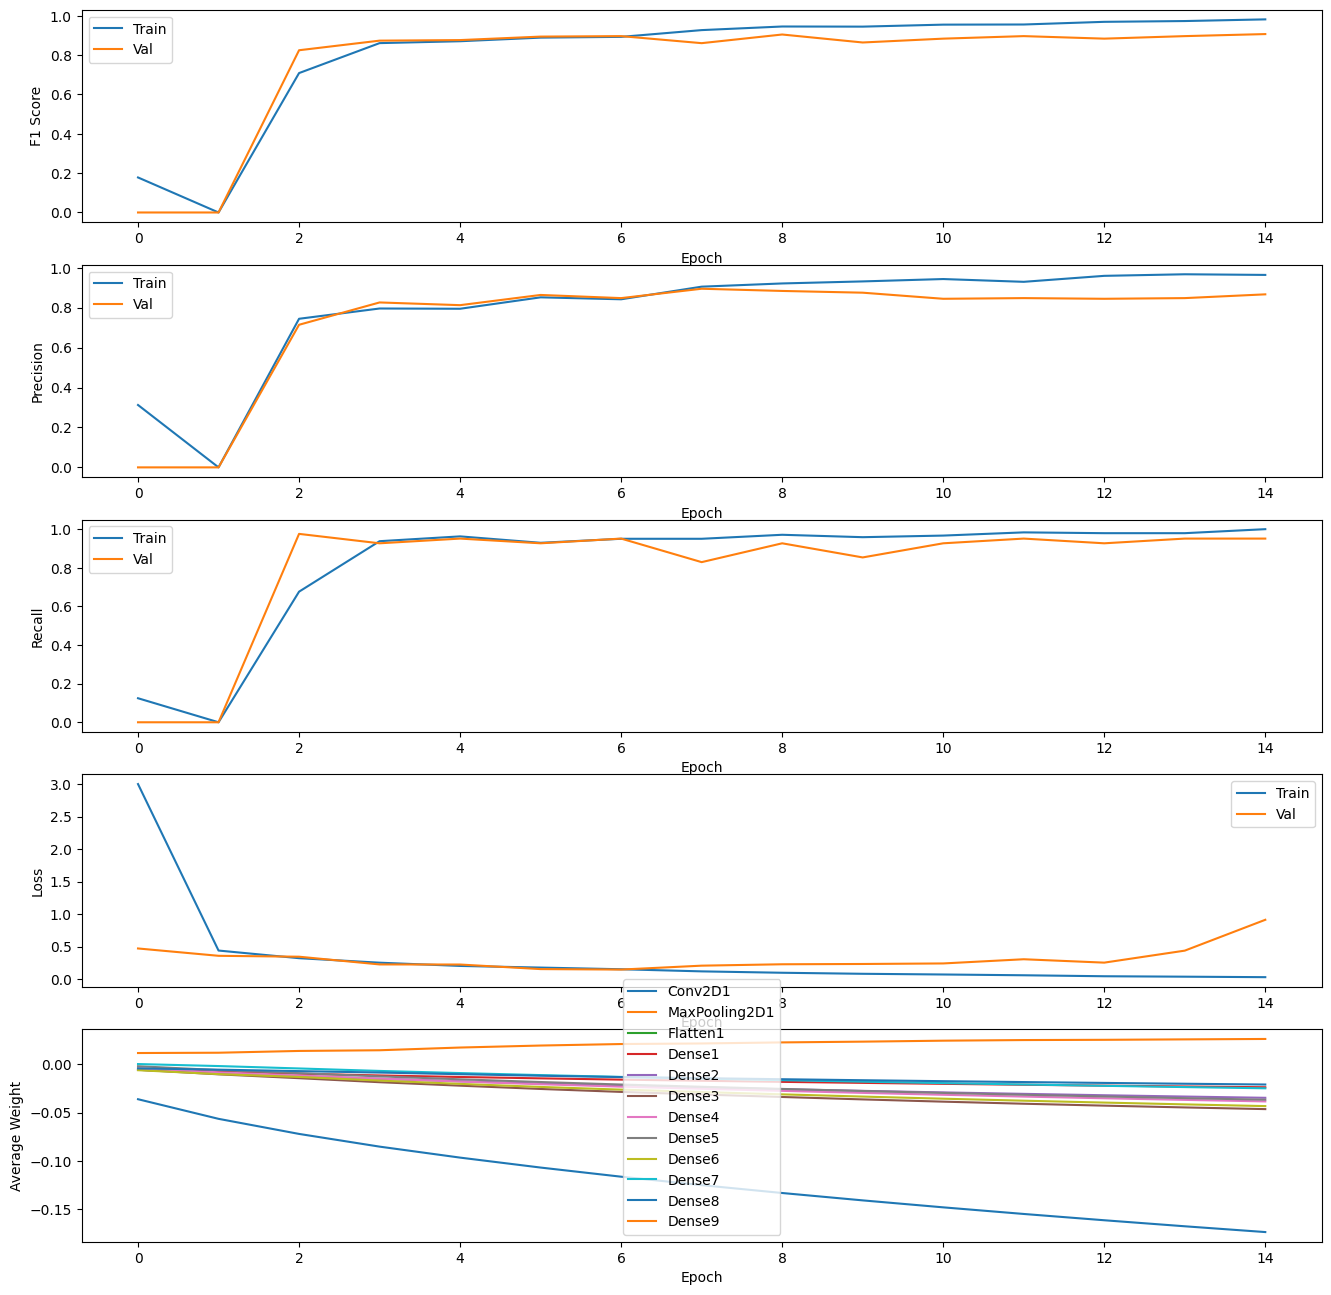

In [55]:
plt.figure(figsize=(16,16))

plt.subplot(5,1,1)
plt.plot('epoch','train_f1_score',data=model_df,label="Train")
plt.plot('epoch','val_f1_score',data=model_df,label='Val')
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()

plt.subplot(5,1,2)
plt.plot('epoch','train_precision',data=model_df,label="Train")
plt.plot('epoch','val_precision',data=model_df,label='Val')
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.legend()

plt.subplot(5,1,3)
plt.plot('epoch','train_recall',data=model_df,label="Train")
plt.plot('epoch','val_recall',data=model_df,label='Val')
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend()

plt.subplot(5,1,4)
plt.plot('epoch','train_loss',data=model_df,label="Train")
plt.plot('epoch','val_loss',data=model_df,label='Val')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(5,1,5)
for col in model_layers.columns:
  plt.plot(model_layers.index,col,data=model_layers,label=col)
plt.xlabel("Epoch")
plt.ylabel("Average Weight")
plt.legend()

plt.show()

## 2.5.2 Evaluation on test set

In [56]:
pred_probs_tuned=nn_model_5_128.predict(X_test_3D) #Obtain probabilities for each test image
test_loss_tuned, test_accuracy_tuned, test_f1_score_tuned, test_precision_tuned, test_recall_tuned = nn_model_5_128.evaluate(X_test_3D, y_test)
print("Tuned Neural Network Test Accuracy", test_accuracy_tuned)
print("Tuned Neural Network Test F1 Score",test_f1_score_tuned)
print("Tuned Neural Network Test Precision", test_precision_tuned)
print("Tuned Neural Network Test Recall",test_recall_tuned)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.9588 - f1_score: 0.9500 - loss: 1.6179 - precision: 0.9665 - recall_1: 0.9349
Tuned Neural Network Test Accuracy 0.9646017551422119
Tuned Neural Network Test F1 Score 0.9512194395065308
Tuned Neural Network Test Precision 0.9750000238418579
Tuned Neural Network Test Recall 0.9285714030265808


In [57]:
print_confusion_matrix(y_test,preds=pred_probs_tuned)


Confusion Matrix 
	True Negatives: 71
	False Positives: 0
	False Negatives: 16
	True Positive: 26


## 2.5.3 Evaluation on outside test set

In [58]:
X_test_out_removed_array = X_test_out.to_numpy()
X_test_out_3D = X_test_out_removed_array.reshape(X_test_out.shape[0],256,256)

In [59]:
pred_probs_tuned=nn_model_5_128.predict(X_test_out_3D) #Obtain probabilities for each test image
test_out_loss_tuned, test_out_accuracy_tuned, test_out_f1_score_tuned, test_out_precision_tuned, test_out_recall_tuned = nn_model_5_128.evaluate(X_test_out_3D, y_test_out)
print("Tuned Neural Network Test Accuracy", test_out_accuracy_tuned)
print("Tuned Neural Network Test F1 Score",test_out_f1_score_tuned)
print("Tuned Neural Network Test Precision", test_out_precision_tuned)
print("Tuned Neural Network Test Recall",test_out_recall_tuned)

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - accuracy: 0.8992 - f1_score: 0.9284 - loss: 1.8513 - precision: 0.9258 - recall_1: 0.9377
Tuned Neural Network Test Accuracy 0.7425000071525574
Tuned Neural Network Test F1 Score 0.7831578254699707
Tuned Neural Network Test Precision 0.6763636469841003
Tuned Neural Network Test Recall 0.9300000071525574


In [60]:
# import pickle
# pickle.dump(nn_model_5_128, open('neural_net_covid_v_all.pkl','wb'))

In [61]:
# nn_model = pickle.load(open('neural_net.pkl','rb'))

# Next Steps
# 3. Future Opportunities: [1: Covid + Pneumonia; 0: normal]
## Regroup data with all Covid and Pneumonia records in the positive class and all normal records in the negative class
### Goal: Create model to distinguish between sick and healthy lungs

## 3.1 Relabel the target

In [62]:
binary_label = []
for i in range(len(df)):
  if df.loc[i]['label'] == 2:
    binary_label += [0]
  else:
    binary_label += [1]
df['binary_label'] = binary_label

binary_label = []
for i in range(len(df_test)):
  if df_test.loc[i]['label'] == 2:
    binary_label += [0]
  else:
    binary_label += [1]
df_test['binary_label'] = binary_label

binary_label = []
for i in range(len(df_test_out)):
  if df_test_out.loc[i]['label'] == 2:
    binary_label += [0]
  else:
    binary_label += [1]
df_test_out['binary_label'] = binary_label

## 3.2 Exploratory Data Analysis

In [63]:
df['feature0'].groupby(df['binary_label']).count()

binary_label
0    382
1    522
Name: feature0, dtype: int64

In [64]:
features=[col for col in df.columns if col not in ['index','Unnamed: 0','label','binary_label','Image_Path']]
X_train=df[features]
X_test=df_test[features]
X_test_out=df_test_out[features]
y_train=df['binary_label']
y_test=df_test['binary_label']
y_test_out=df_test_out['binary_label']

In [65]:
X_train.shape

(904, 65536)

## 3.3 Hyperparameters:

models were tuned in other jupyter notebook files, the hyperparameters for lr, dt, rf, xgb, svm models are as bellow:

<img src="picture3.png" alt="My Image" width="600"/>

## 3.4 Fine tuned lr, dt, rf, xgb, svm models:

In [66]:
# Load the models
with open(model_path + '/best_lr_model_augument_2.pkl', 'rb') as file:
    best_lr = pickle.load(file)

with open(model_path + '/best_decision_tree_model_augument_2.pkl', 'rb') as file:
    best_dt = pickle.load(file)

with open(model_path + '/best_random_forest_model_augument_2.pkl', 'rb') as file:
    best_rf = pickle.load(file)

with open(model_path + '/best_xgboost_model_augument_2.pkl', 'rb') as file:
    best_xgb = pickle.load(file)

with open(model_path + '/best_svm_model_augument_2.pkl', 'rb') as file:
    best_svm_rbf = pickle.load(file)

with open(model_path + '/best_svm_linear_model_augument_2.pkl', 'rb') as file:
    best_svm_linear = pickle.load(file)

## 3.4.1 Evaluation on test set

In [67]:
best_model_dict_4 = {'Name':[],
             'Accuracy': [],
             'Precision': [],
             'Recall': [],
             'F1_score': []}

# best lr 
accuracy, recall, precision, f1 = get_score(best_lr, X_test, y_test)
add_to_dict(best_model_dict_4, 'Logistic Regression', accuracy, precision, recall, f1)

# best dt
accuracy, recall, precision, f1 = get_score(best_dt, X_test, y_test)
add_to_dict(best_model_dict_4, 'Decision Tree', accuracy, precision, recall, f1)

# best rf
accuracy, recall, precision, f1 = get_score(best_rf, X_test, y_test)
add_to_dict(best_model_dict_4, 'Random Forest', accuracy, precision, recall, f1)

# best xgb
accuracy, recall, precision, f1 = get_score(best_xgb, X_test, y_test)
add_to_dict(best_model_dict_4, 'Xgboost', accuracy, precision, recall, f1)

# best_svm rbf
accuracy, recall, precision, f1 = get_score(best_svm_rbf, X_test, y_test)
add_to_dict(best_model_dict_4, 'Supper Vector Machine: rbf', accuracy, precision, recall, f1)

# best_svm linear
accuracy, recall, precision, f1 = get_score(best_svm_linear, X_test, y_test)
add_to_dict(best_model_dict_4, 'Supper Vector Machine: linear', accuracy, precision, recall, f1)

# print results
results_4 = pd.DataFrame(best_model_dict_4)
results_4

#results_4.to_csv('result_augument_data_2.csv', index=False)

,Name,Accuracy,Precision,Recall,F1_score
0,Logistic Regression_saga,0.840708,0.842105,0.914286,0.876712
1,Decision Tree,0.769912,0.823529,0.800000,0.811594
2,Random Forest,0.831858,0.814815,0.942857,0.874172
3,Xgboost,0.867257,0.866667,0.928571,0.896552
4,Supper Vector Machine: rbf,0.867257,0.910448,0.871429,0.890511
5,Supper Vector Machine: linear,0.752212,0.762500,0.871429,0.813333


## 3.4.2 Evaluation on outside test set

In [68]:
best_model_dict_5 = {'Name':[],
             'Accuracy': [],
             'Precision': [],
             'Recall': [],
             'F1_score': []}

# best lr 
accuracy, recall, precision, f1 = get_score(best_lr, X_test_out, y_test_out)
add_to_dict(best_model_dict_5, 'Logistic Regression', accuracy, precision, recall, f1)

# best dt
accuracy, recall, precision, f1 = get_score(best_dt, X_test_out, y_test_out)
add_to_dict(best_model_dict_5, 'Decision Tree', accuracy, precision, recall, f1)

# best rf
accuracy, recall, precision, f1 = get_score(best_rf, X_test_out, y_test_out)
add_to_dict(best_model_dict_5, 'Random Forest', accuracy, precision, recall, f1)

# best xgb
accuracy, recall, precision, f1 = get_score(best_xgb, X_test_out, y_test_out)
add_to_dict(best_model_dict_5, 'Xgboost', accuracy, precision, recall, f1)

# best_svm rbf
accuracy, recall, precision, f1 = get_score(best_svm_rbf, X_test_out, y_test_out)
add_to_dict(best_model_dict_5, 'Supper Vector Machine: rbf', accuracy, precision, recall, f1)

# best_svm linear
accuracy, recall, precision, f1 = get_score(best_svm_linear, X_test_out, y_test_out)
add_to_dict(best_model_dict_5, 'Supper Vector Machine: linear', accuracy, precision, recall, f1)

# print results
results_5 = pd.DataFrame(best_model_dict_5)
results_5

#results_5.to_csv('result_augument_data_2_out.csv', index=False)

,Name,Accuracy,Precision,Recall,F1_score
0,Logistic Regression_saga,0.73000,0.780702,0.890000,0.831776
1,Decision Tree,0.65250,0.756369,0.791667,0.773616
2,Random Forest,0.71375,0.757997,0.908333,0.826384
3,Xgboost,0.71875,0.762973,0.906667,0.828637
4,Supper Vector Machine: rbf,0.72375,0.768034,0.905000,0.830910
5,Supper Vector Machine: linear,0.70250,0.769345,0.861667,0.812893


## 3.5 Tuned Neural Network

In [69]:
X_train_removed_array = X_train.to_numpy()
X_train_3D = X_train_removed_array.reshape(X_train.shape[0],256,256)
X_test_removed_array = X_test.to_numpy()
X_test_3D = X_test_removed_array.reshape((X_test.shape[0],256,-1))


## 3.5.1 Model Trainning

In [70]:
def create_nn_new(input_shape):
    model = Sequential() # Creates instance of Sequential model, model for NN where layers are added up in sequence (One input tensor and one output tensor)
    model.add(Conv2D(filters=100, kernel_size=5, activation='relu', input_shape=input_shape)) # 1D convolutional layer to model, 64 neurons, each filter extracts different features from input data
    # Kernel size 3, each filter covers 3 units in the input dimension. Relu, allows the model to capture non-linear relationships
    model.add(MaxPooling2D(pool_size=2)) # Layer reduces the dimensionality of the data by taking the max value over a window of 2 units along each feature dimension
    # Makes the model more efficient and less sensitive to small variation in the position of features
    model.add(Flatten()) # Adds flatten layer, converts multidimensional output of previous layers into a 1D array for fully connected layer
    model.add(Dense(128, activation='relu')) # Adds dense layer (fully connected), 50 neurons and again uses relu activation
    add_layer(model,5,128)
    model.add(Dense(64, activation='relu')) # Adds dense layer (fully connected), 50 neurons and again uses relu activation
    model.add(Dense(32, activation='relu')) # Adds dense layer (fully connected), 50 neurons and again uses relu activation
    model.add(Dense(1, activation='sigmoid'))  # Adds another dense layer, 1 unit for output layer, single neuron whose task is regression. Activation is linear for regression
    opt = tf.keras.optimizers.Adam(learning_rate=0.005, beta_1=0.999, beta_2=0.999)
    f1_score = tf.keras.metrics.F1Score(threshold=0.5)
    precision = tf.keras.metrics.Precision(thresholds=0.5)
    recall = tf.keras.metrics.Recall(thresholds=0.5)
    model.compile(optimizer=opt, loss=BinaryCrossentropy(), metrics=['accuracy',f1_score,precision,recall]) # Compiles the model, uses Adam optimizer which combines the advantages of Adaptive Gradient Algorithm and Root Mean Square Propagation
    # Uses MSE as loss function, typical for regression task
    return model

input_shape = (256,256,1)  # 12 features, 1 row per input
nn_model_new = create_nn_new(input_shape)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [71]:
model_new_history = nn_model_new.fit(X_train_3D, y_train, epochs=15, batch_size=32, callbacks=[customCallback()], validation_split=0.15)

Epoch 1/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - accuracy: 0.5290 - f1_score: 0.6133 - loss: 25.6525 - precision_1: 0.5826 - recall_2: 0.6646 - val_accuracy: 0.5368 - val_f1_score: 0.6986 - val_loss: 0.6926 - val_precision_1: 0.5368 - val_recall_2: 1.0000
Epoch 2/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.5845 - f1_score: 0.7377 - loss: 0.6721 - precision_1: 0.5845 - recall_2: 1.0000 - val_accuracy: 0.5368 - val_f1_score: 0.6986 - val_loss: 0.7674 - val_precision_1: 0.5368 - val_recall_2: 1.0000
Epoch 3/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.5845 - f1_score: 0.7377 - loss: 0.6774 - precision_1: 0.5845 - recall_2: 1.0000 - val_accuracy: 0.5368 - val_f1_score: 0.6986 - val_loss: 0.6951 - val_precision_1: 0.5368 - val_recall_2: 1.0000
Epoch 4/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.5845 - f1_score: 0.7377 - loss: 0.6028 - precision_1: 0.5845 - recall_2: 1.0000 - val_accuracy: 0.5368 - val_f1_score: 0.6986 - val_loss: 0.5639 - val_precision

## 3.5.2 Evaluation on test set

In [72]:
pred_probs_tuned=nn_model_new.predict(X_test_3D) #Obtain probabilities for each test image
test_loss_tuned, test_accuracy_tuned, test_f1_score_tuned, test_precision_tuned, test_recall_tuned = nn_model_new.evaluate(X_test_3D, y_test)
print("Tuned Neural Network Test Accuracy", test_accuracy_tuned)
print("Tuned Neural Network Test F1 Score",test_f1_score_tuned)
print("Tuned Neural Network Test Precision", test_precision_tuned)
print("Tuned Neural Network Test Recall",test_recall_tuned)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 0.7884 - f1_score: 0.8392 - loss: 2.7627 - precision_1: 0.8286 - recall_2: 0.8507
Tuned Neural Network Test Accuracy 0.7964601516723633
Tuned Neural Network Test F1 Score 0.8391607999801636
Tuned Neural Network Test Precision 0.8219178318977356
Tuned Neural Network Test Recall 0.8571428656578064


In [73]:
model_df = pd.DataFrame(columns=['epoch','train_f1_score','val_f1_score','train_precision','val_precision','train_recall','val_recall','train_loss','val_loss'])
model_df['epoch'] = model_new_history.epoch
model_df['train_f1_score'] = model_new_history.history['f1_score']
model_df['val_f1_score'] = model_new_history.history['val_f1_score']
model_df['train_precision'] = model_new_history.history['precision_1']
model_df['val_precision'] = model_new_history.history['val_precision_1']
model_df['train_recall'] = model_new_history.history['recall_2']
model_df['val_recall'] = model_new_history.history['val_recall_2']
model_df['train_loss'] = model_new_history.history['loss']
model_df['val_loss'] = model_new_history.history['val_loss']

name = []
for layer in nn_model_new.layers:
  name += [str(type(layer)).split("'")[1].split(".")[5]]
name_count = pd.Series(name).value_counts()
name_count_dict = name_count.to_dict()
for i in name_count_dict.keys():
  start = 0
  for j in range(name_count_dict[i]):
    ind = name.index(i,start)
    name[ind] = str(name[ind]) + str(j + 1)
    start = j + 1
model_layers = pd.DataFrame(columns=name)
for i,w in enumerate(nn_model_new.all_weights):
  model_layers.loc[i] = w

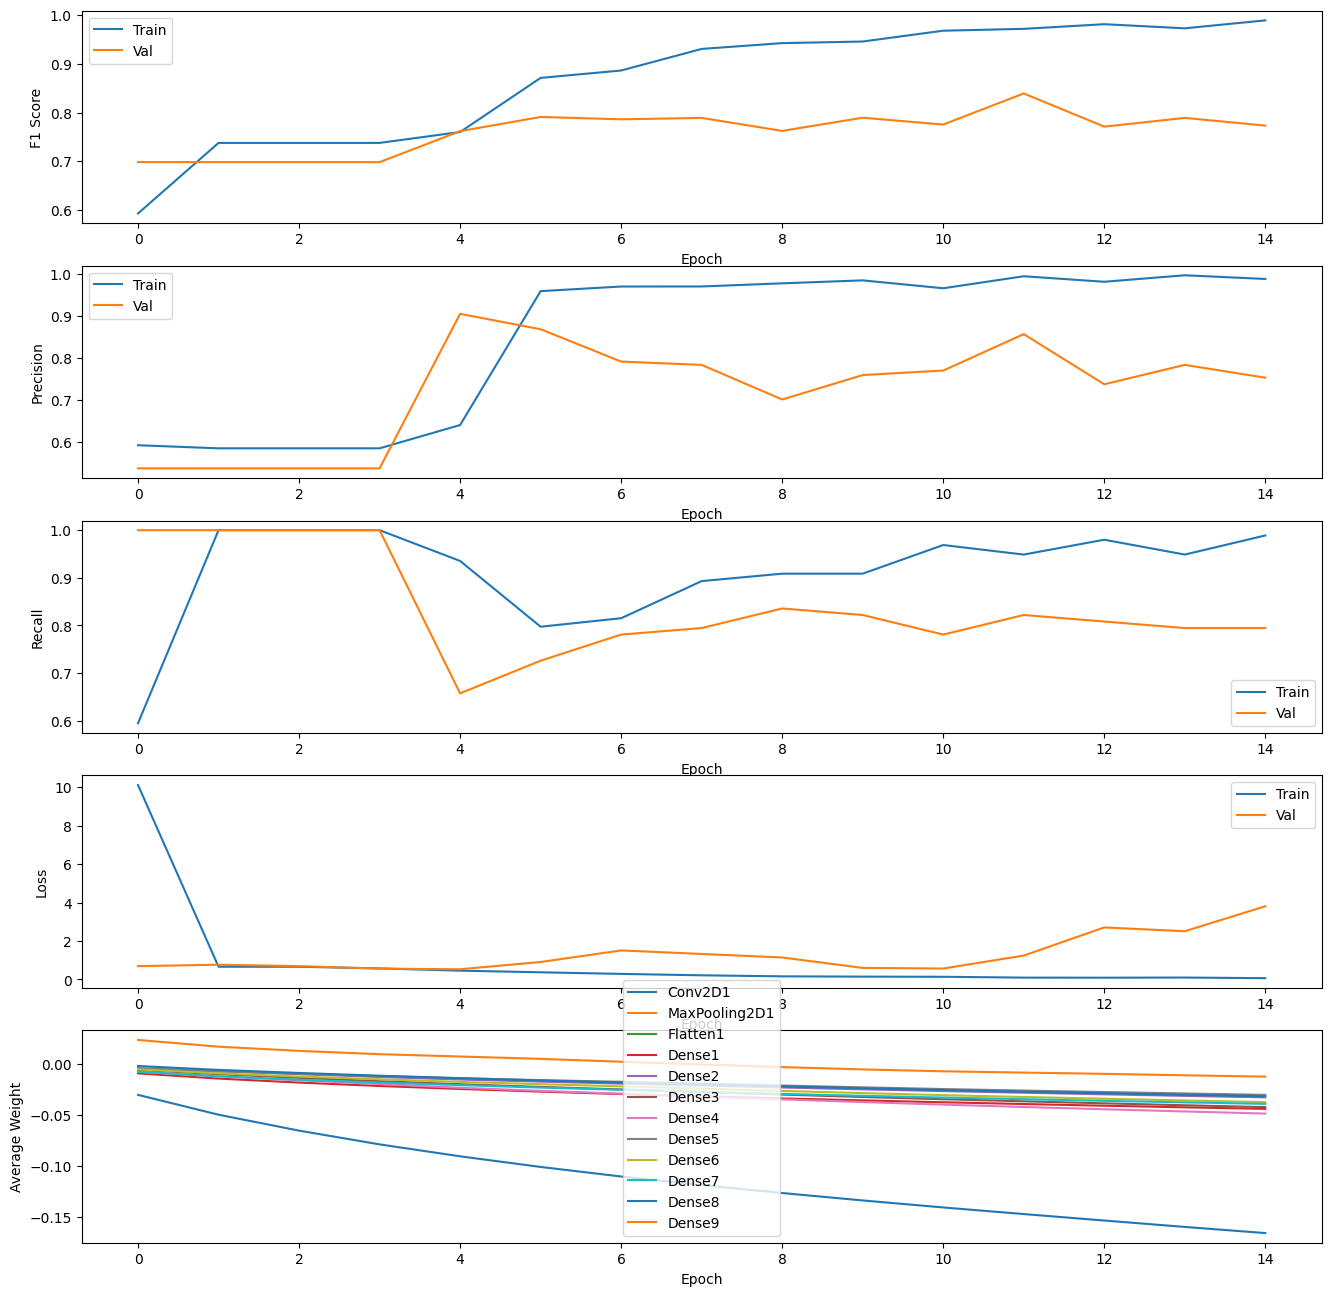

In [74]:
plt.figure(figsize=(16,16))

plt.subplot(5,1,1)
plt.plot('epoch','train_f1_score',data=model_df,label="Train")
plt.plot('epoch','val_f1_score',data=model_df,label='Val')
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()

plt.subplot(5,1,2)
plt.plot('epoch','train_precision',data=model_df,label="Train")
plt.plot('epoch','val_precision',data=model_df,label='Val')
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.legend()

plt.subplot(5,1,3)
plt.plot('epoch','train_recall',data=model_df,label="Train")
plt.plot('epoch','val_recall',data=model_df,label='Val')
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend()

plt.subplot(5,1,4)
plt.plot('epoch','train_loss',data=model_df,label="Train")
plt.plot('epoch','val_loss',data=model_df,label='Val')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(5,1,5)
for col in model_layers.columns:
  plt.plot(model_layers.index,col,data=model_layers,label=col)
plt.xlabel("Epoch")
plt.ylabel("Average Weight")
plt.legend()

plt.show()

In [75]:
# pickle.dump(nn_model_new, open('neural_net_covid_v_all_2.pkl','wb'))

## 3.5.3 Evaluation on outside test

In [76]:
X_test_out_removed_array = X_test_out.to_numpy()
X_test_out_3D = X_test_out_removed_array.reshape((X_test_out.shape[0],256,-1))

In [77]:
pred_probs_tuned=nn_model_new.predict(X_test_out_3D) #Obtain probabilities for each test image
test_loss_tuned, test_accuracy_tuned, test_f1_score_tuned, test_precision_tuned, test_recall_tuned = nn_model_new.evaluate(X_test_out_3D, y_test_out)
print("Tuned Neural Network Test Accuracy", test_accuracy_tuned)
print("Tuned Neural Network Test F1 Score",test_f1_score_tuned)
print("Tuned Neural Network Test Precision", test_precision_tuned)
print("Tuned Neural Network Test Recall",test_recall_tuned)

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 256ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step - accuracy: 0.8169 - f1_score: 0.8949 - loss: 4.1604 - precision_1: 0.9592 - recall_2: 0.8407
Tuned Neural Network Test Accuracy 0.6924999952316284
Tuned Neural Network Test F1 Score 0.7999999523162842
Tuned Neural Network Test Precision 0.7809523940086365
Tuned Neural Network Test Recall 0.8199999928474426
